# Metadata

* Title: **Final Project Report**
* Class: DS 5100
* Date: 7/15/2022
* Student Name: Devin McDonald
* Student Net ID: djm6cz
* This URL: https://github.com/dvnmc/Monte-Carlo-Simulator/blob/main/FinalProjectSubmission.ipynb
* GitHub Repo URL: https://github.com/dvnmc/Monte-Carlo-Simulator

# The Monte Carlo Module

In [1]:
import numpy as np
import pandas as pd
from collections import Counter

class Die():
    '''
    This class is used to create a die that has N sides, or “faces”, and W weights. 
    Additionally, the weights can be changed, and the die can be rolled to select a face.
    '''
    
    def __init__(self, faces):
        '''
        PURPOSE: initialize a Die object
    
        INPUTS
        faces    array of ints, floats, or strings
    
        OUTPUT
        None
        '''
        self.faces = faces
        self.weights = np.ones(len(self.faces))
        self.__privatedf = pd.DataFrame({'faces': self.faces, 
                                         'weights': self.weights})
        
    def change_weight(self, face_val, new_weight):
        '''
        PURPOSE: change the weight of a single side of a die object
    
        INPUTS
        face_val     int, float, or string      
        new_weight   int or float 
    
        OUTPUT
        None 
        '''
        self.face_val = face_val
        try:
            self.new_weight = float(new_weight)
        except ValueError:
            print('Please input a number of type int, float, or str.')
        if self.face_val not in self.faces:
            return 'This is not a valid face.'
        else:
            index = self.faces.index(self.face_val)
            self.weights[index] = new_weight
            self.__privatedf = pd.DataFrame({'faces': self.faces, 
                                             'weights': self.weights})
            
    def roll_die(self, n_rolls = 1):
        '''
        PURPOSE: roll the die one or more times
    
        INPUTS
        n_rolls      int  
    
        OUTPUT
        *not stored* list of ints
        '''
        self.n_rolls = n_rolls
        outcome = self.__privatedf.sample(weights = self.weights).values[0][0]
        if type(outcome) == np.float64:
            return [int(self.__privatedf.sample(weights = self.weights).\
                values[0][0]) for i in range(self.n_rolls)]
        else:
            return [self.__privatedf.sample(weights = self.weights).\
                values[0][0]for i in range(self.n_rolls)]
    
    def current_faces_and_weights(self):
        '''
        PURPOSE: show the die’s current set of faces and weights
    
        INPUTS
        None
    
        OUTPUT
        *private*  pd.DataFrame
        '''
        return self.__privatedf
    
    
class Game():
    '''
    This class is used to create a game that consists of rolling of one or more dice 
    of the same kind. The dice can be rolled one or more times. 
    '''
    
    def __init__(self, dice):
        '''
        PURPOSE: initialize a Game object 
    
        INPUTS
        dice     list of already instantiated similar Die objects
    
        OUTPUT
        None
        '''
        self.dice = dice
        for i in range(len(self.dice)):
            first = sorted(self.dice[0].current_faces_and_weights()['faces'].to_numpy())
            rest = sorted(self.dice[i].current_faces_and_weights()['faces'].to_numpy())
            if rest == first:
                self.dice = dice
            else:
                raise Exception('Please input dice with equivalent faces.')
                self.dice = []
        
    def play(self, n_rolls):
        '''
        PURPOSE: roll the dice a specified number of times
    
        INPUTS
        n_rolls  int
    
        OUTPUT
        None
        '''
        self.n_rolls = n_rolls
        outcomes = np.array([die.roll_die(n_rolls) for die in self.dice])
        index_labels = ['roll ' + str(x + 1) for x in range(n_rolls)]
        self.__privatedf = pd.DataFrame(index = index_labels)
        for i in range(len(self.dice)):
            self.__privatedf['die ' + str(i + 1)] = outcomes[i]
                  
    def show(self, wide_or_narrow = 'wide'):
        '''
        PURPOSE: show the user the results of the most recent play
        
        INPUTS
        wide_or_narrow   str (either "wide" or "narrow")
    
        OUTPUT           
        *private*        pd.DataFrame (either stacked or unstacked)        
        '''
        self.wide_or_narrow = wide_or_narrow
        if self.wide_or_narrow == 'wide':
            return self.__privatedf
        elif self.wide_or_narrow == 'narrow':
            return self.__privatedf.stack().to_frame('face')
        else:
            raise Exception('Enter either "wide" or "narrow" (defaults to "wide")')
            

class Analyzer():
    '''
    This class takes the results of a single game and computes various descriptive statistical properties.
    '''
    
    def __init__(self, game):
        '''
        PURPOSE: initialize an Analyzer object

        INPUTS
        game     already instantiated Game object

        OUTPUT
        None
        '''
        self.game = game
    
    def jackpot(self):
        '''
        PURPOSE: compute how many times the game resulted in all identical faces
    
        INPUTS
        None
    
        OUTPUT
        total_jackpots   int
        '''
        jackpots = []
        rows = []
        for i in range(len(self.game.show())):
            row = list(self.game.show().iloc[i])
            rows.append(row)
            if len(set(rows[i])) == 1:
                jackpots.append(1)
            else:
                jackpots.append(0)
        index_labels = ['roll ' + str(x + 1) for x in range(self.game.n_rolls)]
        self.jackpot_df = pd.DataFrame(index = index_labels)
        self.jackpot_df['jackpot'] = jackpots
        self.total_jackpots = len([x for x in jackpots if x == 1])
        return self.total_jackpots
        
    def combo(self):
        '''
        PURPOSE: compute the distinct combinations of faces rolled, along with their counts
    
        INPUTS
        None
    
        OUTPUT
        None
        '''
        rows = sorted([tuple(self.game.show().iloc[x]) for x in range(self.game.n_rolls)])
        combo_keys = Counter(rows).keys()
        count_vals = Counter(rows).values()
        self.combo_df = pd.DataFrame({
            'faces': combo_keys, 
            'count': count_vals})
        index_labels = ['combo ' + str(x + 1) for x in range(len(combo_keys))]
        self.combo_df.index = index_labels
    
    def face_counts(self):
        '''
        PURPOSE: compute how many times a given face is rolled in each event
    
        INPUTS
        None
    
        OUTPUT
        None
        '''
        rows = [list(self.game.show().iloc[x]) for x in range(self.game.n_rolls)]
        index_labels = ['roll ' + str(x + 1) for x in range(self.game.n_rolls)]
        count = [Counter(x) for x in rows]
        self.face_counts_df = pd.DataFrame.from_dict(count)
        self.face_counts_df.index = index_labels
        self.face_counts_df = self.face_counts_df.fillna(0)
        columns_sorted = sorted(self.face_counts_df.columns)
        self.face_counts_df = self.face_counts_df.reindex(columns=columns_sorted)
        for i in range(len(columns_sorted)):
            self.face_counts_df[i+1] = self.face_counts_df[i+1].apply(np.int64)
        faces = ['faces']
        self.face_counts_df.columns = pd.MultiIndex.from_tuples(
            list(zip(faces*len(columns_sorted), columns_sorted)))

# Test Module

In [2]:
import unittest

class MonteCarloTestSuite(unittest.TestCase):
    '''
    This class is used to apply the unittest unit testing framework to 
    each method in each class of the monte_carlo.py file.
    '''
    
    def test_init_Die(self):
        '''
        PURPOSE: ensure Die object is initialized correctly 
    
        INPUTS
        None
    
        OUTPUT
        None
        '''
        die = Die([1,2,3,4,5,6])
        weights = die.weights
        expected = np.ones(6)
        self.assertTrue((weights == expected)[0])
    
    def test_change_weight_invalid(self):
        '''
        PURPOSE: test whether change_weight method informs the user when 
        attempting to change the weight of an invalid face
    
        INPUTS
        None
    
        OUTPUT
        None
        '''
        die = Die([1,2,3,4,5,6])
        die_new_weight = die.change_weight(12,5)
        expected = 'This is not a valid face.'
        self.assertEqual(die_new_weight, expected)
        
    def test_change_weight_valid(self):
        '''
        PURPOSE: test whether change_weight method operates correctly 
        and returns None when changing the weight of a valid face
    
        INPUTS
        None
    
        OUTPUT
        None
        '''
        die = Die([1,2,3,4,5,6])
        die_new_weight = die.change_weight(1,5)
        expected = None
        self.assertEqual(die_new_weight, expected)
        
    def test_roll_die(self):
        '''
        PURPOSE: test whether roll_die method operates correctly 
        and returns a list with length equal to n_rolls
    
        INPUTS
        None
    
        OUTPUT
        None
        '''
        die = Die(['H', 'T'])
        outcome = die.roll_die(10)
        expected = len(range(10))
        self.assertEqual(len(outcome), expected)
    
    def test_current_faces_and_weights(self):
        '''
        PURPOSE: test whether current_faces_and_weights method 
        operates correctly and returns a pandas DataFrame
    
        INPUTS
        None
    
        OUTPUT
        None
        '''
        die1 = Die(['H', 'T'])
        die2 = Die([1,2,3,4,5,6])
        die1_faces_and_weights = die1.current_faces_and_weights
        die2_faces_and_weights = die2.current_faces_and_weights
        expected1 = (type(die1_faces_and_weights) == type(die2_faces_and_weights))
        expected2 = (type(die1_faces_and_weights) == pd.core.frame.DataFrame)
        self.assertEqual(True, expected1, expected2)
        
    
    
    def test_init_Game(self):
        '''
        PURPOSE: ensure Game object is initialized correctly 
    
        INPUTS
        None
    
        OUTPUT
        None
        '''
        die1 = Die([1,2,3,4,5,6])
        die2 = Die(['H', 'T'])
        self.assertRaises(Exception, lambda: Game([die1, die1, die2]))
    
    def test_play(self):
        '''
        PURPOSE: test whether play method operates correctly and 
        returns None
    
        INPUTS
        None
    
        OUTPUT
        None
        '''
        die = Die([1,2,3,4,5,6])
        game = Game([die, die, die])
        play = game.play(20)
        expected = None
        self.assertEqual(play, expected)
        
    def test_show_invalid(self):
        '''
        PURPOSE: test whether show method raises an exception to the 
        user when incorrectly attempting to specify how the DataFrame
        should be returned (i.e., when inputting something other than 
        "wide"or "narrow")
    
        INPUTS
        None
    
        OUTPUT
        None
        '''
        die = Die([1,2,3,4,5,6])
        game = Game([die, die, die])
        play = game.play(20)
        self.assertRaises(Exception, lambda: game.show('invalid'))
        
    def test_show_valid(self):
        '''
        PURPOSE: test whether show method operates correctly and returns
        a pandas DataFrame when correctly specifying how the DataFrame
        should be returned (in this case as "narrow)
    
        INPUTS
        None
    
        OUTPUT
        None
        '''
        die = Die([1,2,3,4,5,6])
        game = Game([die, die, die])
        play = game.play(20)
        df = type(game.show('narrow'))
        expected = pd.core.frame.DataFrame
        self.assertEqual(df, expected)
        
        
        
    def test_init_Analyzer(self):
        '''
        PURPOSE: ensure Analyzer object is initialized correctly 
    
        INPUTS
        None
    
        OUTPUT
        None
        '''
        die = Die([1,2,3,4,5,6])
        game = Game([die, die, die])
        play = game.play(20)
        analysis = Analyzer(game)
        self.assertTrue(str(type(analysis.__init__(game))) == "<class 'NoneType'>")
    
    def test_jackpot(self):
        '''
        PURPOSE: test whether jackpot method operates correctly and allows the 
        user to access the jackpot_df pandas DataFrame as a public attribute
    
        INPUTS
        None
    
        OUTPUT
        None
        '''
        die = Die([1,2,3,4,5,6])
        game = Game([die, die, die])
        play = game.play(20)
        analysis = Analyzer(game)
        analysis.jackpot()
        df = type(analysis.jackpot_df)
        expected = pd.core.frame.DataFrame
        self.assertEqual(df, expected)
        
    def test_combo(self):
        '''
        PURPOSE: test whether combo method operates correctly and allows the 
        user to access the combo_df pandas DataFrame as a public attribute
    
        INPUTS
        None
    
        OUTPUT
        None
        '''
        die = Die([1,2,3,4,5,6])
        game = Game([die, die, die])
        play = game.play(20)
        analysis = Analyzer(game)
        analysis.combo()
        df = type(analysis.combo_df)
        expected = pd.core.frame.DataFrame
        self.assertEqual(df, expected)
        
        
    def test_face_counts(self):
        '''
        PURPOSE: test whether face_counts method operates correctly and allows the 
        user to access the face_counts_df pandas DataFrame as a public attribute
    
        INPUTS
        None
    
        OUTPUT
        None
        '''
        die = Die([1,2,3,4,5,6])
        game = Game([die, die, die])
        play = game.play(20)
        analysis = Analyzer(game)
        analysis.face_counts()
        df = type(analysis.face_counts_df)
        expected = pd.core.frame.DataFrame
        self.assertEqual(df, expected)
        
# Running the following raises an error in a jupyter notebook:       
        
# if __name__ == '__main__':
#     unittest.main(verbosity=3)

# It is included as normal code in the unit_tests.py file

# Test Results

# Scenarios

Code blocks with your scenarios and their outputs. 

These should have appropriate import statements even though the code is now in the same notebook as the classes it calls. 

In [3]:
import os
path = os.path.expanduser('~/Desktop/Monte-Carlo-Simulator/src')
os.chdir(path)

In [4]:
import matplotlib.pyplot as plt

from monte_carlo import Die
from monte_carlo import Game
from monte_carlo import Analyzer

## Scenario 1

1. Create a fair coin (with faces H and T) and one unfair coin, in which one of the faces has a weight of 5 and the others 1.

In [5]:
fair_coin = Die(['H', 'T'])
unfair_coin = Die(['H', 'T'])
unfair_coin.change_weight('H', 5)

*Example docstring (for change_weight method):*

In [6]:
print(unfair_coin.change_weight.__doc__)


        PURPOSE: change the weight of a single side of a die object
    
        INPUTS
        face_val     int, float, or string      
        new_weight   int or float 
    
        OUTPUT
        None 
        


2. Play a game of 1000 flips of three coins with all fair dice.

In [7]:
n_tosses = 1000

In [8]:
fair_game = Game([fair_coin, fair_coin, fair_coin])
fair_play = fair_game.play(n_tosses)

3. Play a game of 1000 flips with two unfair dice and one fair die.

In [9]:
unfair_game = Game([unfair_coin, unfair_coin, fair_coin])
unfair_play = unfair_game.play(n_tosses)

4. For each game, use an Analyzer object to determine the relative frequency of jackpots – getting either all Hs or all Ts.

In [10]:
fair_analysis = Analyzer(fair_game)
fair_analysis.jackpot()

236

In [11]:
unfair_analysis = Analyzer(unfair_game)
unfair_analysis.jackpot()

377

5. Compute relative frequency as the number of jackpots over the total number of rolls.

In [12]:
fair_jp_freq = fair_analysis.jackpot() / n_tosses
unfair_jp_freq = unfair_analysis.jackpot() / n_tosses

6. Show your results, comparing the two relative frequencies, in a simple bar chart.

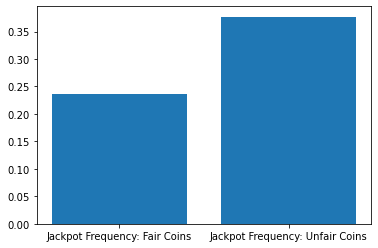

In [13]:
labels = ['Jackpot Frequency: Fair Coins', 'Jackpot Frequency: Unfair Coins'] 
freqs = [fair_jp_freq, unfair_jp_freq]

plt.bar(labels, freqs)
plt.show();

## Scenario 2

1. Create a fair die and two unfair dice, all of six sides with the faces 1 through 6. One unfair die (Type 1) will weight 6 five times more than the others (i.e. it has weight of 5 and the others a weight of 1 each). The other unfair die (Type 2) will  weight 1 five times more than the others.

In [14]:
fair_die = Die([1, 2, 3, 4, 5, 6])
unfair_die1 = Die([1, 2, 3, 4, 5, 6])
unfair_die2 = Die([1, 2, 3, 4, 5, 6])

In [15]:
unfair_die1.change_weight(6, 5)
unfair_die2.change_weight(1, 5)

*Example display of current faces and weights for unfair_die1 and unfair_die2*

In [16]:
unfair_die1.current_faces_and_weights()

,faces,weights
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0
5,6,5.0


In [17]:
unfair_die2.current_faces_and_weights()

,faces,weights
0,1,5.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0
5,6,1.0


2. Play a game of 10000 rolls with 5 fair dice.

In [18]:
n_rolls = 10000

In [19]:
fair_game = Game([fair_die, fair_die, fair_die, fair_die, fair_die])
fair_play = fair_game.play(n_rolls)

3. Play a game of 10000 rolls with 2 unfair dice of type 1, 1 unfair die of type 2, and the rest fair dice.

In [20]:
unfair_game = Game([unfair_die1, unfair_die1, unfair_die2, fair_die, fair_die])
unfair_play = unfair_game.play(n_rolls)

4. For each game, use an Analyzer object to determine the relative frequency of jackpots and show your results, comparing the two relative frequencies, in a simple bar chart.

In [21]:
fair_analysis = Analyzer(fair_game)
fair_analysis.jackpot()
fair_jp_freq = fair_analysis.jackpot() / n_rolls

In [22]:
unfair_analysis = Analyzer(unfair_game)
unfair_analysis.jackpot()
unfair_jp_freq = unfair_analysis.jackpot() / n_rolls

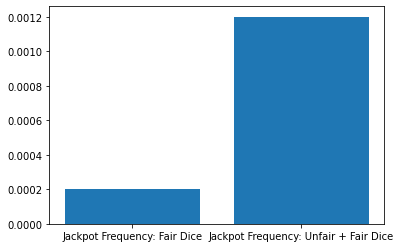

In [23]:
labels = ['Jackpot Frequency: Fair Dice', 'Jackpot Frequency: Unfair + Fair Dice'] 
freqs = [fair_jp_freq, unfair_jp_freq]

plt.bar(labels, freqs)
plt.show();

5. Also compute 10 most frequent combinations of faces for each game. Plot each of these as bar charts.

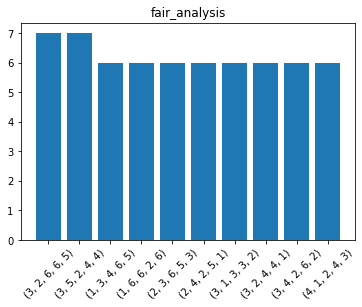

In [24]:
fair_analysis.combo()
labels = fair_analysis.combo_df.nlargest(n=10, columns=['count'])['faces'].to_numpy()
labels = [str(x) for x in labels]
counts = fair_analysis.combo_df.nlargest(n=10, columns=['count'])['count'].to_numpy()

plt.title('fair_analysis') 
plt.bar(labels, counts)
plt.xticks(rotation = 45);

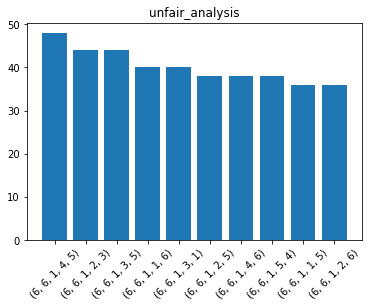

In [25]:
unfair_analysis.combo()
labels = unfair_analysis.combo_df.nlargest(n=10, columns=['count'])['faces'].to_numpy()
labels = [str(x) for x in labels]
counts = unfair_analysis.combo_df.nlargest(n=10, columns=['count'])['count'].to_numpy()

plt.title('unfair_analysis') 
plt.bar(labels, counts)
plt.xticks(rotation = 45);

## Scenario 3

1. Create a "die" of letters from a to z with weights based on their frequency of usage. See Appendix for these weights.

In [26]:
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g',
            'h', 'i', 'j', 'k', 'l', 'm', 'n', 
            'o', 'p', 'q', 'r', 's', 't', 'u',
            'v', 'w', 'x', 'y', 'z']

In [27]:
weights = [8.4966, 2.0720, 4.5388, 3.3844, 11.1607, 1.8121, 2.4705,
           3.0034, 7.5448, 0.1965, 1.1016, 5.4893, 3.0129, 6.6544, 
           7.1635, 3.1671, 0.1962, 7.5809, 5.7351, 6.9509, 3.6308,
           1.0074, 1.2899, 0.2902, 1.7779, 0.2722]

In [28]:
ab_die = Die(alphabet)

In [29]:
for i in range(26):
    ab_die.change_weight(alphabet[i], weights[i])

In [30]:
ab_die.current_faces_and_weights().head()

,faces,weights
0,a,8.4966
1,b,2.0720
2,c,4.5388
3,d,3.3844
4,e,11.1607


2. Play a game involving 5 of these dice with 1000 rolls.

In [31]:
n_rolls = 1000

In [32]:
word_game = Game([ab_die] * 5)

In [33]:
word_play = word_game.play(n_rolls)

3. How many combos can you that look like actual English words?

*In order to make this slightly more thorough, I went about this by importing / downloading words from nltk.corpus. I then compared my 5 letter combinations to actual 5 letter words from nltk.corpus.*

In [34]:
import nltk
from nltk.corpus import words
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     /Users/devinmcdonald/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [35]:
possible_words = []
for i in range(len(word_game.show())):
    letters = list(word_game.show().iloc[i])  
    possible_word = ''.join(letters)
    possible_words.append(possible_word) 

In [36]:
five_letter_words = [x for x in words.words() if len(x) == 5]
real_words = [i for i in possible_words if i in five_letter_words]
real_words

['troop', 'ectad', 'ergot', 'negus']

In [37]:
real_word_frequency = len(real_words) / n_rolls
real_word_frequency

0.004

4. Based on your eye count, what is the relative frequency of these words versus the rest?

*Based on my eye count, the relative frequency of these words versus the rest often came out to be 0.001, which is is typically less than the previouly shown method's frequency.*

*However, the frequency of words that **look** like English words typically ranged from a frequency of 0.001-0.01.*

*One can also return a random sample from possible_words using the following code:*

`import random`

`print([x for x in random.sample(possible_words, 50)])`

# Directory Listing

A code block that executes the following bash command: 

```bash
!ls -lRF -o
```

In [38]:
!ls -lRF -o ..

total 232
-rw-r--r--@ 1 devinmcdonald  39256 Jul 14 12:14 FinalProjectSubmission.ipynb
-rw-r--r--  1 devinmcdonald   1071 Jul 14 12:19 LICENSE
-rw-r--r--  1 devinmcdonald   6200 Jul 14 12:19 README.md
-rw-r--r--  1 devinmcdonald  60351 Jul 14 12:19 scenarios.ipynb
-rw-r--r--  1 devinmcdonald    382 Jul 14 12:19 setup.py
drwxr-xr-x  5 devinmcdonald    160 Jul 14 12:20 src/
drwxr-xr-x  4 devinmcdonald    128 Jul 14 12:19 tests/

../src:
total 16
-rw-r--r--  1 devinmcdonald     0 Jul 14 12:19 __init__.py
drwxr-xr-x  3 devinmcdonald    96 Jul 14 12:20 __pycache__/
-rw-r--r--  1 devinmcdonald  7256 Jul 14 12:19 monte_carlo.py

../src/__pycache__:
total 24
-rw-r--r--  1 devinmcdonald  8224 Jul 14 12:20 monte_carlo.cpython-37.pyc

../tests:
total 24
-rw-r--r--  1 devinmcdonald  1622 Jul 14 12:19 test_results.txt
-rw-r--r--  1 devinmcdonald  6618 Jul 14 12:19 unit_tests.py


# Installation Output Listing
    
A code block that executes the code to install your your package and outputs a successful installation.

In [39]:
!pip install ..

Processing /Users/devinmcdonald/Desktop/Monte-Carlo-Simulator
  Preparing metadata (setup.py) ... done
  Created wheel for Monte-Carlo-Simulator: filename=Monte_Carlo_Simulator-1.0.0-py3-none-any.whl size=4253 sha256=2c82a144f4a9f64dffb5960a828e44cf3f9dbb2cc2ea3951f5361198ca4c9c63
  Stored in directory: /Users/devinmcdonald/Library/Caches/pip/wheels/f4/fe/16/ec7f0b05cdd4b60afddd071c2122fdb6b3e92ec7cb17aa1367
Successfully built Monte-Carlo-Simulator
  Attempting uninstall: Monte-Carlo-Simulator
    Found existing installation: Monte-Carlo-Simulator 1.0.0
    Uninstalling Monte-Carlo-Simulator-1.0.0:
      Successfully uninstalled Monte-Carlo-Simulator-1.0.0
